In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from crf.comlid_crf import *
from helper.dataset_reader import read_tsv

In [52]:
from tensorflow.python.client import device_lib

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
langid = LanguageIdentifier()

In [30]:
data = read_tsv('../dataset/all-merged-data-140422.tsv')

In [31]:
all_data, words, tags = data

In [32]:
# create list of tuples from all words and all tags
word_tag = list(zip(words, tags))
# print(word_tag)
# convert list to dataframe
df_wordtag = pd.DataFrame(word_tag, columns=['Token','Label'])
# df_wordtag

In [33]:
words = list(set(df_wordtag['Token'].values))
words.append("ENDPAD")
num_words = len(words)
# print(num_words)

In [34]:
tags = list(set(df_wordtag["Label"].values))
num_tags = len(tags)
# print(num_tags)

In [35]:
dt_pair = langid.data_transformer(data)
# dt_pair[0]

In [36]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

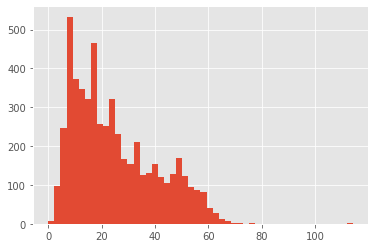

In [37]:
plt.hist([len(s) for s in dt_pair], bins=50)
plt.show()

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in dt_pair]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in dt_pair]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [40]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [41]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            1344500   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 7)            1407      
 tributed)                                                       
                                                           

In [42]:
import tensorflow_addons as tfa

In [43]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", tfa.metrics.F1Score(num_classes=num_tags, threshold=0.5)])

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

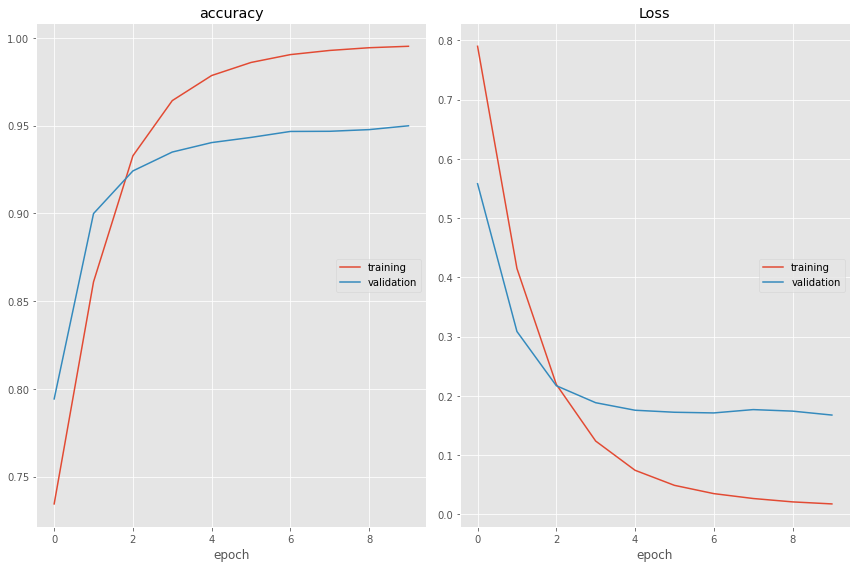

accuracy
	training         	 (min:    0.734, max:    0.995, cur:    0.995)
	validation       	 (min:    0.794, max:    0.950, cur:    0.950)
Loss
	training         	 (min:    0.018, max:    0.790, cur:    0.018)
	validation       	 (min:    0.168, max:    0.558, cur:    0.168)

Epoch 10: val_loss improved from 0.17130 to 0.16769, saving model to ../model\model_weights.h5
113/113 [==============================] - 40s 354ms/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.1677 - val_accuracy: 0.9499
CPU times: total: 12min 14s
Wall time: 6min 34s


In [45]:
%%time

chkpt = ModelCheckpoint("../model/model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

In [46]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 3s 52ms/step - loss: 0.1677 - accuracy: 0.9499


[0.16769398748874664, 0.9498820900917053]

In [57]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *40)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True      	 Pred

----------------------------------------
@jenocrushie   O         	O
yess           EN        	EN
emang          ID        	ID
juaraaa        ID        	ID
bgt            ID        	ID
vietnamese     EN        	ID
cuisine        EN        	EN
!!             O         	O
thank          EN        	EN
youu           EN        	EN
sayaang        ID        	EN
hope           EN        	EN
you            EN        	EN
had            EN        	EN
an             EN        	EN
amazing        EN        	EN
daay           EN        	EN
juga           ID        	ID
🤍              O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN             O         	O
UN            